# Questão 2 - Regressão
Teste dois métodos de aprendizagem de máquina para identificar o que apresenta melhores resultados na previsão do volume de tráfego. Avaliem o impacto de usar validação cruzada (com 10 grupos) e split (70% para treinamento e 30% para teste). Para esse último, execute o experimento duas vezes selecionando as instâncias aleatoriamente para o treinamento e teste e avalie o impacto nos resultados.
Outras informações como dia da semana podem ser inclusas.
 

## Preliminares
Importação de dependências, carregamento da base de dados e observação inicial dos dados.

In [1]:
from scipy import stats
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns

from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', delimiter = ',') # Abrir base de dados

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
df.info() # Obter informações sobre os atributos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Os atributos do tipo object terão de ser analisados e convertidos para valores numéricos mais adiante, no caso de que venham a permanecer na base de dados.

In [4]:
df.isnull().sum() # Obter numero de valores faltando

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

Como nenhum valor está faltando, nenhuma ação adicional foi tomada para corrigir dados ausentes.

## Tratando atributos não numéricos

In [5]:
print("Valores únicos de holiday:", df['holiday'].unique(), "\n")
print("Valores únicos de weather_main:", df['weather_main'].unique(), "\n")
print("Valores únicos de weather_description:", df['weather_description'].unique(), "\n")

Valores únicos de holiday: ['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day'] 

Valores únicos de weather_main: ['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke'] 

Valores únicos de weather_description: ['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze' 'fog'
 'proximity shower rain' 'drizzle' 'moderate rain' 'heavy intensity rain'
 'proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'heavy snow' 'heavy intensity drizzle'
 'snow' 'thunderstorm with heavy rain' 'freezing rain' 'shower snow'
 'light rain and snow' 'light intensity shower rain' 'SQUALLS'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'Sky is Clear' 'very heavy rain'
 'thund

### Holiday

None                         48143
Labor Day                        7
Christmas Day                    6
Thanksgiving Day                 6
Martin Luther King Jr Day        6
New Years Day                    6
State Fair                       5
Memorial Day                     5
Veterans Day                     5
Columbus Day                     5
Independence Day                 5
Washingtons Birthday             5
Name: holiday, dtype: int64


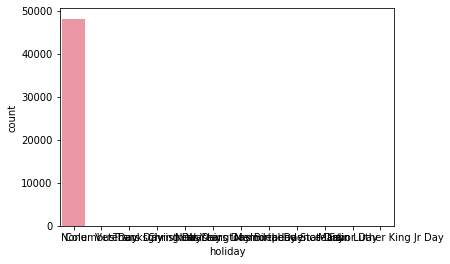

In [6]:
sns.countplot(df['holiday'])
count = df['holiday'].value_counts()
print(count)

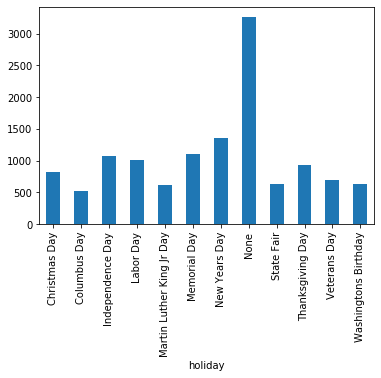

In [7]:
df.groupby('holiday').mean()['traffic_volume'].plot.bar()

Pelo primeiro gráfico, percebe-se que o atributo Holiday está bastante desbalanceado, o que é de se imaginar pois cada feriado só acontece uma vez por ano. 

Contudo, ao mesmo tempo, analisando o segundo gráfico é possível perceber que dias que são feriados contém um tráfego de pessoas significativamente menor.

Mesmo sabendo deste detalhe, foi optado por remover este atributo para evitar gerar um viés no resultado obtido.

In [8]:
df.drop(columns = ['holiday'], inplace = True)

### weather_main e weather_description

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

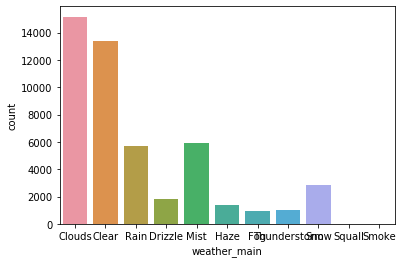

In [9]:
sns.countplot(df['weather_main'])
count = df['weather_main'].value_counts()
count

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

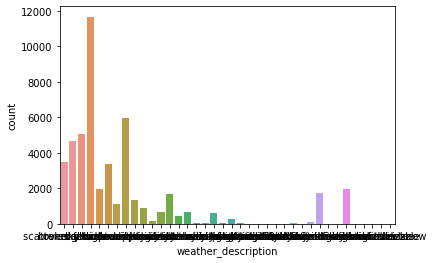

In [10]:
sns.countplot(df['weather_description'])
count = df['weather_description'].value_counts()
count

Há um certo grau de desbalanceamento nestas duas variáveis, sendo que weather_description funciona como uma extensão do weather_main, tanto que cada valor distinto de weather_description está associado ao mesmo valor de weather_main:

In [11]:
for unique_weather in df['weather_main'].unique() :
    loc = df.loc[df['weather_main'] == unique_weather]
    print("Descricoes para", unique_weather, ":", loc['weather_description'].unique())

Descricoes para Clouds : ['scattered clouds' 'broken clouds' 'overcast clouds' 'few clouds']
Descricoes para Clear : ['sky is clear' 'Sky is Clear']
Descricoes para Rain : ['light rain' 'proximity shower rain' 'moderate rain'
 'heavy intensity rain' 'freezing rain' 'light intensity shower rain'
 'very heavy rain']
Descricoes para Drizzle : ['light intensity drizzle' 'drizzle' 'heavy intensity drizzle'
 'shower drizzle']
Descricoes para Mist : ['mist']
Descricoes para Haze : ['haze']
Descricoes para Fog : ['fog']
Descricoes para Thunderstorm : ['proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'thunderstorm with heavy rain'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'thunderstorm with light drizzle'
 'thunderstorm with drizzle']
Descricoes para Snow : ['heavy snow' 'snow' 'shower snow' 'light rain and snow' 'light snow'
 'light shower snow' 'sleet']
Descricoes para Squall : ['SQUALLS']
Descricoes para Smoke :

Vejamos agora a média do tráfego de pessoas para cada valor único de weather_main:

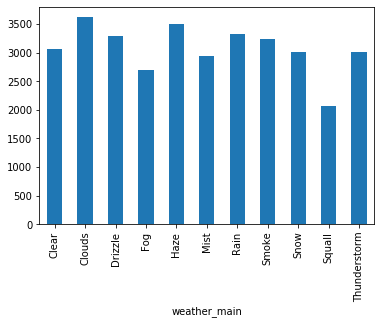

In [12]:
df.groupby('weather_main').mean()['traffic_volume'].plot.bar()

Pela análise do gráfico das médias de tráfego, pode-se perceber que o clima Squall contêm a menor média de tráfego, contudo, este tipo de clima só ocorre 4 vezes, o que talvez seja o motivo pela média ser tão baixa. Quanto ao resto, com exceção de Fog e Mist, todos tiveram uma média acima de 3000 passageiros.

Tendo em vista o desbalanceamento deste atributo e também pela média de cada valor único não explicar muita coisa (i.e. o clima não afeta o tráfego de passageiros), foi optado por remover ambos os atributos 'weather_main' e 'weather_description' da base de dados.

In [13]:
df.drop(columns = ['weather_description', 'weather_main'], inplace = True)

### Date_time
Pro caso do atributo 'date_time' além de conter informações como dia, mês, ano e hora, também pode ser usado para criar outros atributos, como o caso para dia da semana. Logo, foi optado por dividir este atributo em outros 5 (dia, mês, ano, hora e dia da semana), sendo estes todos atributos numéricos.

In [14]:
#df['date_time'] = df['date_time'].apply(lambda s : s.split(" "))
dt = df['date_time'].to_list()
hours = []
years = []
months = []
days = []
weekdays = []

for d in dt:
    split = d.split(" ")
    split2 = split[0].split("-")
    
    years.append(int(split2[0]))
    months.append(int(split2[1]))
    days.append(int(split2[2]))
    
    hours.append(int(split[1].split(':')[0]))

for i in range(len(hours)):
    weekdays.append(datetime.datetime(years[i], months[i], days[i]).weekday())
    
dt_df = pd.DataFrame({"day": days, "month": months, "year": years, "hour": hours, "weekday": weekdays})

df = df.join(dt_df)
df = df.drop(columns = ['date_time'])
df

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,day,month,year,hour,weekday
0,288.28,0.0,0.0,40,5545,2,10,2012,9,1
1,289.36,0.0,0.0,75,4516,2,10,2012,10,1
2,289.58,0.0,0.0,90,4767,2,10,2012,11,1
3,290.13,0.0,0.0,90,5026,2,10,2012,12,1
4,291.14,0.0,0.0,75,4918,2,10,2012,13,1
...,...,...,...,...,...,...,...,...,...,...
48199,283.45,0.0,0.0,75,3543,30,9,2018,19,6
48200,282.76,0.0,0.0,90,2781,30,9,2018,20,6
48201,282.73,0.0,0.0,90,2159,30,9,2018,21,6
48202,282.09,0.0,0.0,90,1450,30,9,2018,22,6


## Analisando correlação

In [15]:
correl = df.corr()
correl.style.background_gradient(cmap = 'coolwarm')

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,day,month,year,hour,weekday
temp,1,0.00906854,-0.0197552,-0.101976,0.130299,0.0229017,0.223738,0.134945,0.112089,-0.00770762
rain_1h,0.00906854,1,-8.98346e-05,0.00481813,0.0047137,-0.00229363,0.00129768,0.000441939,0.00342121,-0.00691954
snow_1h,-0.0197552,-8.98346e-05,1,0.0279309,0.000733435,0.0157888,0.0204121,-0.00351937,0.00984913,-0.0149276
clouds_all,-0.101976,0.00481813,0.0279309,1,0.0670538,0.0481116,-0.00913346,-0.0728609,0.054418,-0.0397152
traffic_volume,0.130299,0.0047137,0.000733435,0.0670538,1,-0.00758739,-0.00253292,0.00475323,0.352401,-0.149544
day,0.0229017,-0.00229363,0.0157888,0.0481116,-0.00758739,1,0.00861361,0.0121924,-0.00937314,0.0086776
month,0.223738,0.00129768,0.0204121,-0.00913346,-0.00253292,0.00861361,1,-0.158688,0.00186516,0.010741
year,0.134945,0.000441939,-0.00351937,-0.0728609,0.00475323,0.0121924,-0.158688,1,-0.00754237,-0.012313
hour,0.112089,0.00342121,0.00984913,0.054418,0.352401,-0.00937314,0.00186516,-0.00754237,1,-0.00385763
weekday,-0.00770762,-0.00691954,-0.0149276,-0.0397152,-0.149544,0.0086776,0.010741,-0.012313,-0.00385763,1


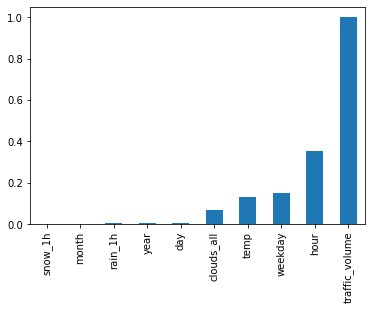

In [16]:
df.corr().abs()["traffic_volume"].sort_values().plot.bar()

A análise da correlação dos atributos mostra que todos os pares distintos possuem uma correlação fraca, em relação ao atributo desejado 'traffic_volume', os atributos 'snow_1h' 'month' 'rain_1h' 'year' e 'day' apresentam uma correlação baixíssima e portanto foram descartados, uma vez que estes não contribuem para determinar o valor do atributo alvo.

In [17]:
df.drop(columns = ['snow_1h', 'month', 'rain_1h', 'year', 'day'], inplace = True)

O atributo 'hour' é o que possui a maior correlação em relação a 'traffic_volume', contudo, isso pode ser explicado pelo fato de que os horários de pico coincidem com os maiores valores de hora:

Text(0, 0.5, 'Tráfego')

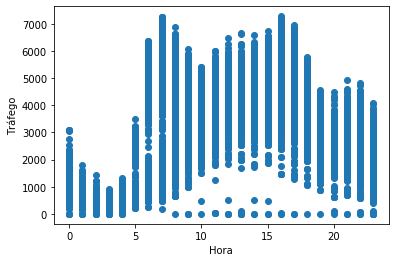

In [18]:
plt.scatter(df['hour'], df['traffic_volume'])
plt.xlabel("Hora")
plt.ylabel("Tráfego")

## Tratamento de outliers

A detecção de outliers será realizada utilizando o Z-score. Valores absolutos para esta métrica acima de 3 serão considerados como outliers.

In [19]:
threshold = 3
outliers = []
total = 0
for column in df.select_dtypes(['float64', 'int64']).columns:
    outs = len(df[(np.abs(stats.zscore(df[column])) >= threshold)])
    total += outs
    if(outs > 0):
        outliers.append(df[(np.abs(stats.zscore(df[column])) >= threshold)])
        print("Outliers em %s: %d (Pct = %.2f)" % (column, outs, outs/len(df)))

print("\nColunas com outliers: %d (Pct = %.2f)" % (len(outliers), len(outliers)/len(df.columns)))
print("\nTotal: %d" % (total))

Outliers em temp: 10 (Pct = 0.00)

Colunas com outliers: 1 (Pct = 0.20)

Total: 10


Pelo resultado acima, apenas a coluna temp possui outlier. Vejamos do que se trata:

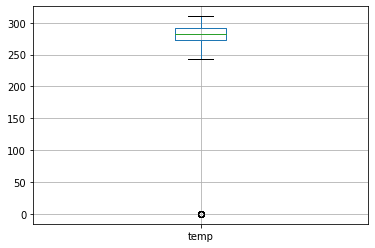

In [20]:
df.boxplot(column = 'temp')

Excluídos os outliers os valores de temp se encontram distribuidos entre aproximadamente 250 e 300, por se tratar de temperatura supõe-se que estejam na escala Kelvin. Sendo que um valor 0 em Kelvin equivaleria a -273.15 em Celsius, logo se trata evidentemente de um valor incorreto, assim, a decisão tomada aqui é por eliminar as linhas que contêm estes outliers.

In [21]:
df = df[(np.abs(stats.zscore(df['temp'])) < threshold)].copy()

df.reset_index(inplace = True) # por algum motivo eliminar linhas resulta em um index mucho louco
df.drop(columns = ['index'], inplace = True)

## Normalização dos atributos
Para evitar dar um peso maior a um atributo específico é feita a normalização destes por meio da padronização.

In [22]:
num = df.select_dtypes(['float64', 'int64']).columns.values
num = np.delete(num, np.argwhere(num == 'traffic_volume'))

scaler = preprocessing.MinMaxScaler()
scaled = pd.concat([pd.DataFrame(scaler.fit_transform(df[num]), columns = num), df['traffic_volume']], axis=1)

scaled.head()

,temp,clouds_all,hour,weekday,traffic_volume
0,0.673215,0.40,0.391304,0.166667,5545
1,0.689412,0.75,0.434783,0.166667,4516
2,0.692711,0.90,0.478261,0.166667,4767
3,0.700960,0.90,0.521739,0.166667,5026
4,0.716107,0.75,0.565217,0.166667,4918


## Teste usando split 70/30 aleatório
Inicialmente é feita a divisão das partições usando 70% para treinamento e 30% para teste, esta divisão foi realizada duas vezes de maneira aleatória.

In [23]:
train1, test1 = model_selection.train_test_split(scaled.copy(), test_size = 0.3, random_state = 7, shuffle = True)
train2, test2 = model_selection.train_test_split(scaled.copy(), test_size = 0.3, random_state = 8, shuffle = True)

trainTarget1 = train1['traffic_volume'].copy()
testTarget1 = test1['traffic_volume'].copy()

train1.drop(columns = ['traffic_volume'], inplace = True)
test1.drop(columns = ['traffic_volume'], inplace = True)

trainTarget2 = train2['traffic_volume'].copy()
testTarget2 = test2['traffic_volume'].copy()

train2.drop(columns = ['traffic_volume'], inplace = True)
test2.drop(columns = ['traffic_volume'], inplace = True)

As métricas de desempenho utilizadas para avaliar os resultados obtidos serão o erro médio quadrático (MSE), erro médio absoluto (MAD) e o coeficiente de determinação (R2). Para os dois primeiros, valores próximos de 0 indicam um modelo com baixo erro, enquanto para o último um valor igual a 1 indica que o modelo se ajusta perfeitamente aos dados.

In [24]:
def getMetrics(target, result, model = "Unnamed"):
    print(model)
    print("MSE: %0.5f" % (metrics.mean_squared_error(target, result)))
    print("MAD: %0.5f" % (metrics.mean_absolute_error(target, result)))
    print("R2: %0.5f" % (metrics.r2_score(target, result)))
    print("")

O primeiro algoritmo utilizado será o K-NN com k = 3

In [25]:
k = 3

knn = neighbors.KNeighborsRegressor(n_neighbors = k)
knn.fit(train1, trainTarget1)
resultKNN1 = knn.predict(test1)
resultKNN_train1 = knn.predict(train1)

knn.fit(train2, trainTarget2)
resultKNN2 = knn.predict(test2)
resultKNN_train2 = knn.predict(train2)

Após executar o algoritmo, é feita a consulta das métricas de avaliação do modelo:

In [26]:
getMetrics(testTarget1, resultKNN1, "(Run = 1)\nK-NN (k = 3) vs Test")
getMetrics(trainTarget1, resultKNN_train1, "(Run = 1)\nK-NN (k = 3) vs Train")

getMetrics(testTarget2, resultKNN2, "(Run = 2)\nK-NN (k = 3) vs Test")
getMetrics(trainTarget2, resultKNN_train2, "(Run = 2)\nK-NN (k = 3) vs Train")

(Run = 1)
K-NN (k = 3) vs Test
MSE: 319960.50475
MAD: 325.89637
R2: 0.91935

(Run = 1)
K-NN (k = 3) vs Train
MSE: 135899.85592
MAD: 210.74051
R2: 0.96549

(Run = 2)
K-NN (k = 3) vs Test
MSE: 286433.94813
MAD: 316.25940
R2: 0.92750

(Run = 2)
K-NN (k = 3) vs Train
MSE: 142746.76501
MAD: 214.69904
R2: 0.96382



Pelas métricas acima, percebe-se que o algoritmo K-NN resultou em resultados consideravelmente bons, atingindo um coeficiente de determinação acima de 0.9 em ambas execuções, além de não ter demonstrado acontecer um overfitting, uma vez que os resultados contra o conjunto de treinamento não estão muito superiores à aqueles obtidos durante o teste. Por fim, vejamos os gráficos de dispersão para ambas execuções:

In [27]:
def scatter(x, y, title = None):
    fig, ax = plt.subplots()
    ax.scatter(x, y, c='orange')
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    if title != None:
        plt.title(title)
    plt.show()

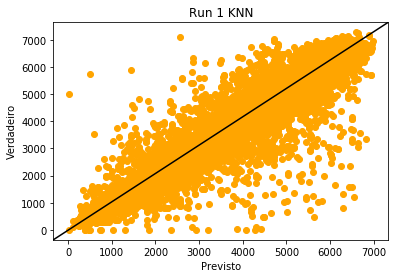

In [28]:
scatter(resultKNN1, testTarget1, "Run 1 KNN")

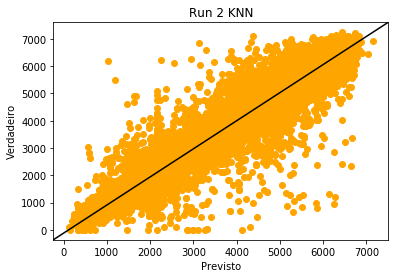

In [29]:
scatter(resultKNN2, testTarget2, "Run 2 KNN")

Em ambas execuções o resultado obtido foi muito parecido. As métricas e o gráfico obtidos acima levam a crer que o modelo conseguiu prever bem o atributo desejado na maior parte dos casos e de maneira consistente, pois mesmo utilizando conjuntos diferentes para treinamento e teste, os resultados obtidos foram semelhantes, porém, como visto no gráfico acima, falhou miseralvelmente em alguns casos, talvez pelo fato de que o atributo holiday foi eliminado por conta do desbalanceamento, sendo que é de se esperar que em dias de feriado o número de passageiros venha a diminuir em comparação com um dia comum.

O segundo algoritmo utilizado será uma árvore de decisão para regressão, enquanto o conjunto de teste e treinamento utilizado será o mesmo do que foi utilizado no K-NN. O parâmetro random_state é utilizado para garantir resultados semi aleatórios (e.g. possam ser replicados posteriormente)

In [30]:
dtr = tree.DecisionTreeRegressor(random_state = 42)

dtr.fit(train1, trainTarget1)
resultDTR1 = dtr.predict(test1)
resultDTR_train1 = dtr.predict(train1)

dtr.fit(train2, trainTarget2)
resultDTR2 = dtr.predict(test2)
resultDTR_train2 = dtr.predict(train2)

In [31]:
getMetrics(testTarget1, resultDTR1, "(Run = 1)\nDecision Tree Regression vs Test")
getMetrics(trainTarget1, resultDTR_train1, "(Run = 1)\nDecision Tree Regression vs Train")

getMetrics(testTarget2, resultDTR2, "(Run = 2)\nDecision Tree Regression vs Test")
getMetrics(trainTarget2, resultDTR_train2, "(Run = 2)\nDecision Tree Regression vs Train")

(Run = 1)
Decision Tree Regression vs Test
MSE: 368575.15170
MAD: 306.12451
R2: 0.90710

(Run = 1)
Decision Tree Regression vs Train
MSE: 1402.91647
MAD: 2.54216
R2: 0.99964

(Run = 2)
Decision Tree Regression vs Test
MSE: 342135.70625
MAD: 298.62785
R2: 0.91340

(Run = 2)
Decision Tree Regression vs Train
MSE: 1516.14844
MAD: 2.21199
R2: 0.99962



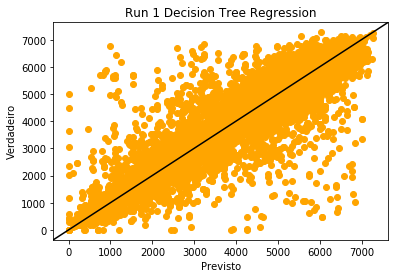

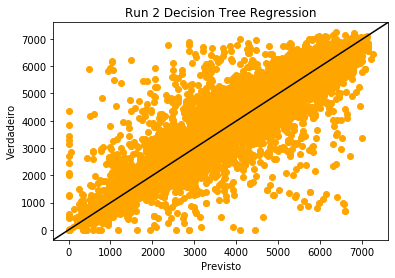

In [32]:
scatter(resultDTR1, testTarget1, "Run 1 Decision Tree Regression")
scatter(resultDTR2, testTarget2, "Run 2 Decision Tree Regression")

Os resultados obtidos com a árvore de decisão foram um pouco inferiores à aqueles obtidos pelo K-NN se comparado a partir dos resultados das métricas, contudo, a forma em que a árvore previu os resultados não aponta uma tendência do modelo superestimar mais do que subestimar (ou o contrário) os valores, ainda percebe-se que houveram várias instâncias com uma alta discrepância entre o valor previsto e o verdadeiro.

Uma coisa que chama mais atenção é que este modelo se ajustou quase perfeitamente ao seu conjunto de treinamento, obtendo métricas bem melhores em relação a este se comparado com o K-NN. Para tentar fazer o modelo generalizar melhor, reexcuto o algoritmo de árvore de decisão, porém com um limite na profundidade da árvore de 12:

In [33]:
dtr_v2 = tree.DecisionTreeRegressor(max_depth = 12, random_state = 42)

dtr_v2.fit(train1, trainTarget1)
resultDTR1_v2 = dtr_v2.predict(test1)
resultDTR_train1_v2 = dtr_v2.predict(train1)

dtr_v2.fit(train2, trainTarget2)
resultDTR2_v2 = dtr_v2.predict(test2)
resultDTR_train2_v2 = dtr_v2.predict(train2)

In [34]:
getMetrics(testTarget1, resultDTR1_v2, "(Run = 1)\nDecision Tree Regression v2 vs Test")
getMetrics(trainTarget1, resultDTR_train1_v2, "(Run = 1)\nDecision Tree Regression v2 vs Train")

getMetrics(testTarget2, resultDTR2_v2, "(Run = 2)\nDecision Tree Regression v2 vs Test")
getMetrics(trainTarget2, resultDTR_train2_v2, "(Run = 2)\nDecision Tree Regression v2 vs Train")

(Run = 1)
Decision Tree Regression v2 vs Test
MSE: 282900.10964
MAD: 291.26244
R2: 0.92869

(Run = 1)
Decision Tree Regression v2 vs Train
MSE: 161616.79525
MAD: 227.82132
R2: 0.95896

(Run = 2)
Decision Tree Regression v2 vs Test
MSE: 263855.18750
MAD: 287.57396
R2: 0.93321

(Run = 2)
Decision Tree Regression v2 vs Train
MSE: 165212.46062
MAD: 229.80517
R2: 0.95813



Reduzir a profundidade máxima da árvore resultou em melhores resultados tanto se comparado ao K-NN quanto a árvore sem limite de profundidade, além de ter atenuado a questão do modelo se ajustar de maneira muito melhor ao conjunto de treino observado anteriormente. Por fim, vejamos o gráfico de dispersão dessa nova execução da árvore:

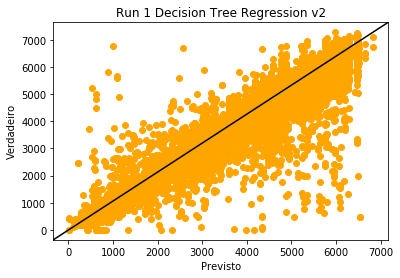

In [35]:
scatter(resultDTR1_v2, testTarget1, "Run 1 Decision Tree Regression v2")

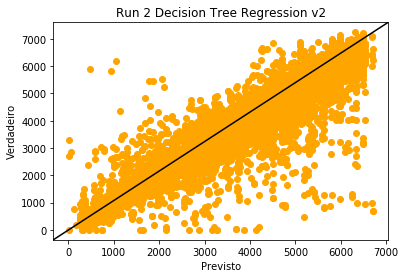

In [36]:
scatter(resultDTR2_v2, testTarget2, "Run 2 Decision Tree Regression v2")

Desta vez, pela análise do gráfico de dispersão percebe-se que o modelo está a superestimar mais do que subestimar os valores da saída em ambas as execuções, e como foi no caso do K-NN houveram vários objetos cujos valores o modelo errou bastante. 

Além disso também é possível observer que há uma pequena faixa perto de 5000 no qual o modelo não previu valores, o que leva a crer que a diminuição da profundidade da árvore resultou na incapacidade de prever alguns conjuntos de valores.

## Teste usando validação cruzada
Utilizando os mesmos algoritmos acima, agora os dados serão divididos em 10 grupos, sendo 9 utilizados para treinamento e 1 utilizado para teste, onde os algoritmos serão executados sobre estes grupos repetidamente até que todo grupo ter sido usado para teste.

In [37]:
splits = 10
results = []
fold = model_selection.KFold(n_splits = splits, random_state = 7, shuffle = True)

X = scaled.copy(deep = True)
Y = X['traffic_volume']

X.drop(columns = ['traffic_volume'], inplace = True)

k = 3
i = 1

knn = neighbors.KNeighborsRegressor(n_neighbors = k)
dtr = tree.DecisionTreeRegressor(random_state = 42)
dtr_v2 = tree.DecisionTreeRegressor(max_depth = 12, random_state = 42)

mse_knn = mad_knn = r2_knn = 0
mse_knn_train = mad_knn_train = r2_knn_train = 0

mse_dtr = mad_dtr = r2_dtr = 0
mse_dtr_train = mad_dtr_train = r2_dtr_train = 0

mse_dtr_v2 = mad_dtr_v2 = r2_dtr_v2 = 0
mse_dtr_train_v2 = mad_dtr_train_v2 = r2_dtr_train_v2 = 0

i = 0
for train_index, test_index in fold.split(scaled):
    i = i + 1
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    knn.fit(X_train, Y_train)
    resultKNN = knn.predict(X_test)
    resultKNN_train = knn.predict(X_train)
    
    mse_knn = mse_knn + metrics.mean_squared_error(Y_test, resultKNN)
    mad_knn = mad_knn + metrics.mean_absolute_error(Y_test, resultKNN)
    r2_knn = r2_knn + metrics.r2_score(Y_test, resultKNN)
    
    mse_knn_train = mse_knn_train + metrics.mean_squared_error(Y_train, resultKNN_train)
    mad_knn_train = mad_knn_train + metrics.mean_absolute_error(Y_train, resultKNN_train)
    r2_knn_train = r2_knn_train + metrics.r2_score(Y_train, resultKNN_train)
    
    dtr.fit(X_train, Y_train)
    resultDTR = dtr.predict(X_test)
    resultDTR_train = dtr.predict(X_train)
    
    mse_dtr = mse_dtr + metrics.mean_squared_error(Y_test, resultDTR)
    mad_dtr = mad_dtr + metrics.mean_absolute_error(Y_test, resultDTR)
    r2_dtr = r2_dtr + metrics.r2_score(Y_test, resultDTR)

    mse_dtr_train = mse_dtr_train + metrics.mean_squared_error(Y_train, resultDTR_train)
    mad_dtr_train = mad_dtr_train + metrics.mean_absolute_error(Y_train, resultDTR_train)
    r2_dtr_train = r2_dtr_train + metrics.r2_score(Y_train, resultDTR_train)
    
    dtr_v2.fit(X_train, Y_train)
    resultDTR_v2 = dtr_v2.predict(X_test)
    resultDTR_train_v2 = dtr_v2.predict(X_train)
    
    mse_dtr_v2 = mse_dtr_v2 + metrics.mean_squared_error(Y_test, resultDTR_v2)
    mad_dtr_v2 = mad_dtr_v2 + metrics.mean_absolute_error(Y_test, resultDTR_v2)
    r2_dtr_v2 = r2_dtr_v2 + metrics.r2_score(Y_test, resultDTR_v2)

    mse_dtr_train_v2 = mse_dtr_train_v2 + metrics.mean_squared_error(Y_train, resultDTR_train_v2)
    mad_dtr_train_v2 = mad_dtr_train_v2 + metrics.mean_absolute_error(Y_train, resultDTR_train_v2)
    r2_dtr_train_v2 = r2_dtr_train_v2 + metrics.r2_score(Y_train, resultDTR_train_v2)
    
    results.append({"Iteration": i,
                   "R2 KNN vs Test": metrics.r2_score(Y_test, resultKNN),
                   "R2 KNN vs Train": metrics.r2_score(Y_train, resultKNN_train),
                   "R2 DTR vs Test": metrics.r2_score(Y_test, resultDTR),
                   "R2 DTR vs Train": metrics.r2_score(Y_train, resultDTR_train),
                   "R2 DTR v2 vs Test": metrics.r2_score(Y_test, resultDTR_v2),
                   "R2 DTR v2 vs Train": metrics.r2_score(Y_train, resultDTR_train_v2)})

Averages:
KNN (k = 3) vs Test
MSE: 284590.48682
MAD: 307.77141
R2: 0.92789

KNN (k = 3) vs Train
MSE: 131559.55528
MAD: 200.43486
R2: 0.96667

DECISION TREE REGRESSION vs Test
MSE: 338271.69361
MAD: 286.86461
R2: 0.91427

DECISION TREE REGRESSION vs Train
MSE: 2037.57965
MAD: 3.13605
R2: 0.99948

DECISION TREE REGRESSION v2 vs Test
MSE: 265281.81207
MAD: 285.26906
R2: 0.93277

DECISION TREE REGRESSION v2 vs Train
MSE: 169422.72396
MAD: 233.95746
R2: 0.95708


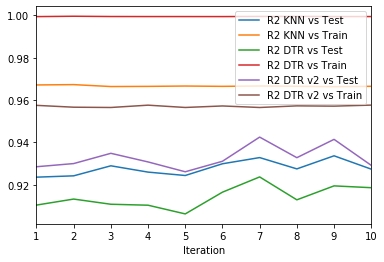

In [38]:
def getAverages(mse, mad, r2, splits):
    print("MSE: %0.5f" % (mse / splits))
    print("MAD: %0.5f" % (mad / splits))
    print("R2: %0.5f" % (r2 / splits))
    
print("Averages:")    
print("KNN (k = %d) vs Test" % (k))
getAverages(mse_knn, mad_knn, r2_knn, splits)

print("\nKNN (k = %d) vs Train" % (k))
getAverages(mse_knn_train, mad_knn_train, r2_knn_train, splits)

print("\nDECISION TREE REGRESSION vs Test")
getAverages(mse_dtr, mad_dtr, r2_dtr, splits)

print("\nDECISION TREE REGRESSION vs Train")
getAverages(mse_dtr_train, mad_dtr_train, r2_dtr_train, splits)

print("\nDECISION TREE REGRESSION v2 vs Test")
getAverages(mse_dtr_v2, mad_dtr_v2, r2_dtr_v2, splits)

print("\nDECISION TREE REGRESSION v2 vs Train")
getAverages(mse_dtr_train_v2, mad_dtr_train_v2, r2_dtr_train_v2, splits)

pd.DataFrame(results).plot.line(x = "Iteration",
                                y = ["R2 KNN vs Test", "R2 KNN vs Train", "R2 DTR vs Test", "R2 DTR vs Train", "R2 DTR v2 vs Test", "R2 DTR v2 vs Train"])

Usando a validação cruzada, a média dos os resultados obtidos foram similares em relação a aqueles vistos anteriormente usando o particionamento.

Enquanto que observando o gráfico, é possível perceber que os todos os algoritmos durante o treinamento geraram modelos que se ajustam aos dados de maneira consistente, sem responder melhor a um conjunto particular.

Por outro lado, durante o teste, todos os algoritmos responderam melhor a certos conjuntos, o que leva a crer que tais conjuntos possuem propriedades estatísticas semelhantes ao conjunto de treinamento da mesma iteração, contudo, a diferença no R^2 não chega a ser gritante.

Por fim, o que se vê é que mesmo utilizando técnicas diferentes de validação, o desempenho obtido foi bastante semelhante, contudo se vasculhado mais profundamente, os resultados da validação cruzada podem ajudar a entender melhor onde o modelo veio a errar mais.